<h1><font color="#15E5B9 " size=4>NLP Transformers</font></h1>



<h1><font color="#15E5B9 " size=6>Custom NER fine-tuning with RoBERTalex</font></h1>



<div style="text-align: right">
<font size=3 color="GREY">Author: Juan Carlos Rivera</font><br>


---


</div>

#### **Previous notes**

What is RoBERTalex? It is a transformer's RoBERTa pretained model. This particular model has been pretrained with a vast corpora of documents within the Spanish-language legal domain (legislation, treatises and so forth). It has been developed under the Spanish National Plan for Language Technologies. Credit for this pretrained model should be given to Asier Gutiérrez-Fandiño, Jordi Armengol-Estapé, Aitor Gonzalez-Agirre and Marta Villegas (see [citation](https://arxiv.org/abs/2110.12201)). For furhter details, please check on [Hugging Face](https://huggingface.co/PlanTL-GOB-ES/RoBERTalex).

Some of the functions used here were taken from M. Rahman's notebook on BERT, available in [Kaggle](https://www.kaggle.com/code/mdmustafijurrahman/bert-named-entity-recognition-ner-data/notebook).




#### **Installing and importing Libraries**


In [ ]:
!pip install transformers seqeval[gpu]

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification

#### **Check GPU**

In [3]:
import torch
torch.cuda.is_available()

True

#### **Loading data**
This NB is ready to take in a csv file containing the dataset. The one used to develop th NB looked like this:

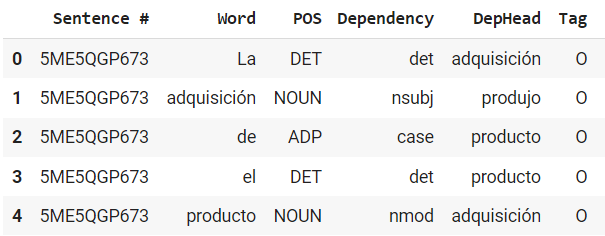

Where the Tag = O will be the one corresponding with the tokens which do not belong to any particular class. It is also important to keep track of the sentences' ID as transformers operate on a sentence basis.


In [ ]:
data = pd.read_csv("dataset.csv", encoding='UTF-8')
data.head()

We can check how many classes we have and how many entities of each are present on the dataset

In [ ]:
print("Number of classes: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

#### **Transform the dataset to fit the model**

The model will need to be fed with just two variables, namely: 'sentence', containing the raw text of each sentence and 'word_labels', which lists separated by commas each tag within the sentence

In [6]:
# Generate "sentence" and "word_labels"
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))

In order to create the labels that will be computed, it is neccessary to create two dictionaries indexing the tags.


In [7]:
label2id = {k: v for v, k in enumerate(data.Tag.unique())}
id2label = {v: k for v, k in enumerate(data.Tag.unique())}

After that, all columns different from "sentence" and "word_labels" are expendable, so they can be removed to keep things clean

In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

#### **Tokenizing and model preparation**

Define tokenizer and model

In [9]:
tokenizer_rbl = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/RoBERTalex')

Define parameters

In [10]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 20
LEARNING_RATE = 1e-04
MAX_GRAD_NORM = 20
tokenizer = tokenizer_rbl

Tokenizes at word piece level

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

Prepare the model's input: 'mask', 'id' and 'targets'

In [12]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]  
        word_labels = self.data.word_labels[index]  
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)
        
        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        
        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

Train/test split

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=251)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

Define the corresponding PyTorch dataloaders:

In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#### **Model definition**

In [ ]:
NUM_LABELS=len(id2label)
device = 'cuda' # change to 'cpu' if 'cuda' not available
model = AutoModelForTokenClassification.from_pretrained('PlanTL-GOB-ES/RoBERTalex', num_labels=NUM_LABELS, ignore_mismatched_sizes=True)
model.to(device)

#### **Model training**



In [16]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
tr_logits = outputs[1]
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [17]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

#### **Evaluating the model**

In [19]:
def valid(model, testing_loader):

    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            active_accuracy = mask.view(-1) == 1 
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(targets)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [20]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.2657318115234375
Validation Loss: 0.22430028638336807
Validation Accuracy: 0.9121968550228069


In [ ]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predictions]))

#### **Model use for NER**


In [60]:
tokenizer = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/RoBERTalex')


In [ ]:
sentence = #'''text to predict'''

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())

token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

In [100]:
results = []
res_inx = -1
word_memory = ''
label_memory = ''
for item in wp_preds:
  if item[1]!='O':
    if (label_memory == item[1]):
      new_word = word_memory + item [0]
      chunk_to_append = (new_word, item [1])
      results.pop(res_inx)
      results.insert(res_inx, chunk_to_append)
      word_memory = word_memory + item [0]
      label_memory = item[1]
    else:
      chunk_to_append = (item[0], item [1])
      list(chunk_to_append)
      results.append(chunk_to_append)
      word_memory = item[0]
      label_memory = item[1]
      res_inx = res_inx+1
  else:
    word_memory = item[0]
    label_memory = item[1]

In [ ]:
for i in list(results):
  word = i[0]
  word = word.replace('Ġ', ' ')
  print("Entity:", word, "| Category:", i[1])
 


#### **Save model (and load for testing purposes)**

In [ ]:
import torch
torch.save(model, 'model.pt')

In [ ]:
model2 = torch.load('model.pt')

In [ ]:
from transformers import pipeline
pipe = pipeline(task="token-classification", model=model2.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("Test sentence")